In [23]:
import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax import random
from jax import jit
from jax import lax

import time

from jax_md import space
from jax_md import smap
from jax_md import energy
from jax_md import quantity
from jax_md import simulate
from jax_md import partition

import matplotlib
import matplotlib.pyplot as plt

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

In [3]:
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

element_list = ['W']
degree = 2

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {('W', 'W'): 1.5,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 25,
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../../tungsten_extxyz/model_pair.json")

coefficients = jnp.asarray(model.coefficients[1:])
knots = jnp.asarray(model.bspline_config.knots_map[('W','W')])

In [50]:
Nx = particles_per_side = 10
spacing = jnp.float32(2.0)
side_length = Nx * spacing

R = onp.stack([onp.array(r) for r in onp.ndindex(Nx, Nx, Nx)]) * spacing
R = jnp.array(R, jnp.float64)

In [51]:
print(f"Number of atoms: {R.shape[0]}")
print(f"Box should be larger than 11 for JAX-MD, is: {side_length}")

Number of atoms: 1000
Box should be larger than 11 for JAX-MD, is: 20.0


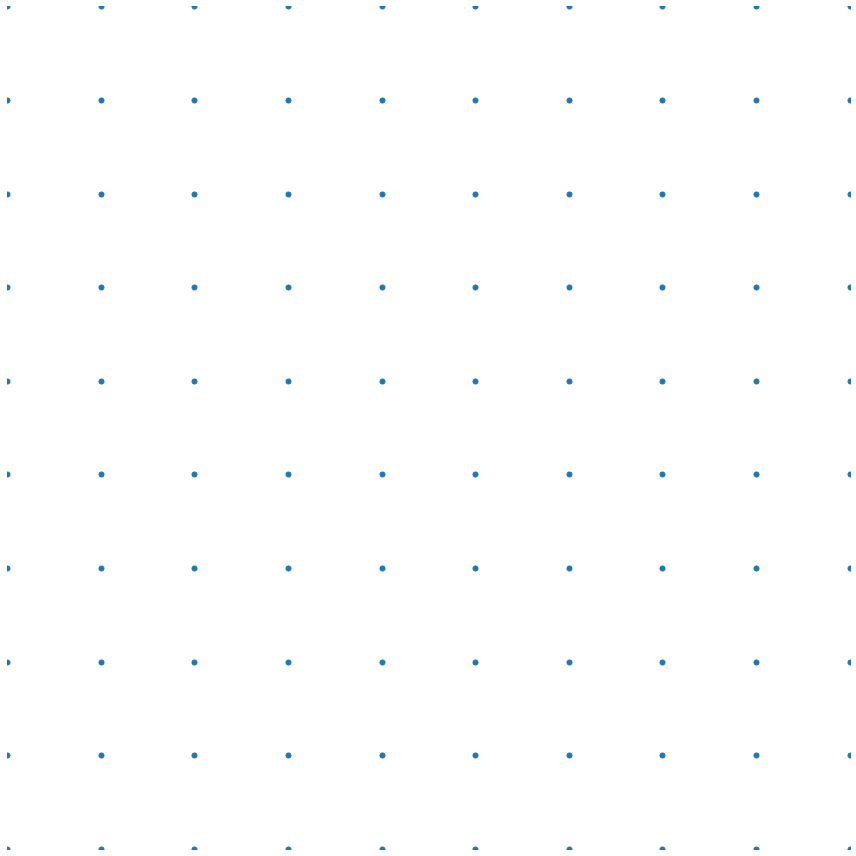

In [24]:
ms = 10
R_plt = onp.array(R)

plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.5)

plt.xlim([0, jnp.max(R[:, 0])])
plt.ylim([0, jnp.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

In [25]:
displacement, shift = space.periodic(side_length)

format = partition.Dense

neighbor_fn, energy_fn = energy.lennard_jones_neighbor_list(displacement, 
                                                            side_length,
                                                            format=format)
energy_fn = jit(energy_fn)

exact_energy_fn = jit(energy.lennard_jones_pair(displacement))

In [52]:
from uf3.jax.potentialsOLD import uf2_neighbor, uf2_pair

displacement, shift = space.periodic(side_length)

format = partition.Dense

neighbor_fn, energy_fn = uf2_neighbor(displacement, side_length, coefficients=coefficients, knots=knots, cutoff=5.5)
energy_fn = jit(energy_fn)

exact_energy_fn = jit(uf2_pair(displacement, knots=knots, coefficients=coefficients))

In [53]:
nbrs = neighbor_fn.allocate(R)

In [54]:
# Run once so that we avoid the jit compilation time.
print('E = {}'.format(energy_fn(R, neighbor=nbrs)))
print('E_ex = {}'.format(exact_energy_fn(R)))

E = 2488.0661064484925
E_ex = 2488.066106448494


In [29]:
%%timeit
energy_fn(R, neighbor=nbrs).block_until_ready()

624 µs ± 7.49 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
%%timeit
exact_energy_fn(R).block_until_ready()

1.87 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [55]:
displacement, shift = space.periodic(side_length)

init_fn, apply_fn = simulate.nve(energy_fn, shift, 1e-3)
state = init_fn(random.PRNGKey(0), R, kT=1e-3, neighbor=nbrs)


def body_fn(i, state):
    state, nbrs = state
    nbrs = nbrs.update(state.position)
    state = apply_fn(state, neighbor=nbrs)
    return state, nbrs


print('Step\tKE\tPE\tTotal Energy\ttime/step')
print('----------------------------------------')
PE = []
KE = []
print_every = 4
step = 0
old_time = time.time_ns()
while step < 40:
    new_state, nbrs = lax.fori_loop(0, 100, body_fn, (state, nbrs))
    if nbrs.did_buffer_overflow:
        print("Neighbor list overflowed, reallocating.")
        nbrs = neighbor_fn.allocate(state.position)
    else:
        state = new_state
        step += 1

    if step % print_every == 0 and step > 0:
        new_time = time.time_ns()
        PE += [energy_fn(state.position, nbrs)]
        KE += [quantity.kinetic_energy(state.velocity)]
        print(
            "{}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}ms".format(
                step * print_every,
                KE[-1],
                PE[-1],
                KE[-1] + PE[-1],
                (new_time - old_time) / print_every / 100.0 / 1000000.0,
            )
        )
        old_time = new_time



Step	KE	PE	Total Energy	time/step
----------------------------------------


/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


16	1.86	2487.76	2489.62		38.42ms
32	30.08	2459.54	2489.62		31.21ms
48	303.83	2185.78	2489.62		29.97ms
Neighbor list overflowed, reallocating.


/opt/anaconda/envs/uf3/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


64	351.56	2131.63	2483.19		56.01ms
80	320.68	2149.65	2470.33		41.02ms
96	324.12	2133.35	2457.47		39.51ms
112	345.02	2093.15	2438.18		39.87ms
128	347.59	2058.43	2406.03		39.64ms
144	366.92	2019.81	2386.73		39.59ms
160	377.21	1990.23	2367.43		39.80ms


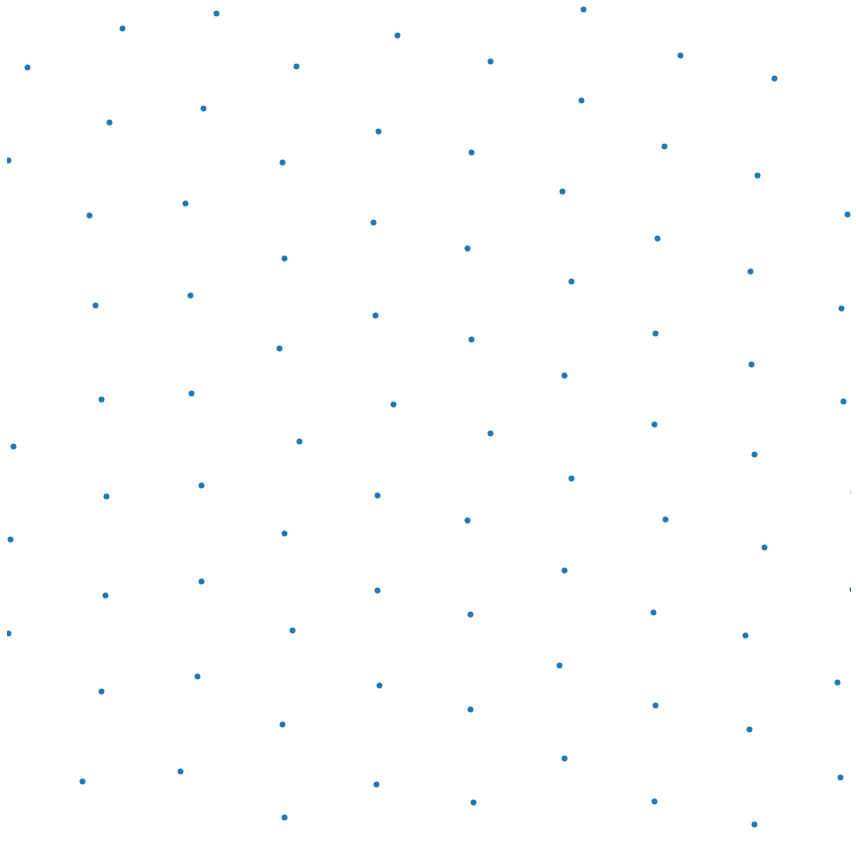

In [43]:
ms = 10
R_plt = onp.array(state.position)

plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.5)

plt.xlim([0, jnp.max(R[:, 0])])
plt.ylim([0, jnp.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))